In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date

from file import save_file


In [2]:
# Define the ticker symbol
tickerSymbol = 'FNGS'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2022-1-1', end=date.today())
history.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-07-13 00:00:00-04:00,51.480000,52.139999,48.619999,48.619999,683100,0.0,0.0,0.0
2024-07-20 00:00:00-04:00,49.439999,50.375000,46.049999,47.200001,499800,0.0,0.0,0.0
2024-07-27 00:00:00-04:00,47.599998,49.080002,44.950001,45.740002,742000,0.0,0.0,0.0
2024-08-03 00:00:00-04:00,41.799999,45.970001,41.619999,45.970001,2040400,0.0,0.0,0.0
2024-08-10 00:00:00-04:00,45.950001,48.770000,45.630001,48.610001,433800,0.0,0.0,0.0


In [3]:
max_weeks = 50

In [4]:
# Calculate the percent change for the given period
gap = (1/40)*100
option_prices = {
    # 1: [44/0.5], # -1500%
    6: [44/1.42],
    19: [44/2.9],
    32: [44/4.15],
    36: [44/4.53],
}
print('option leverages:')
for w in option_prices:
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
print('mean option leverage, break even:')
for w in option_leverage:
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

option leverages:
	 6w 31.0
	19w 15.2
	32w 10.6
	36w  9.7
mean option leverage, break even:
	 6w 31.0  5.7%
	19w 15.2  9.1%
	32w 10.6 11.9%
	36w  9.7 12.8%
option gap: 2.50%


In [5]:

stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.mean()  * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = stock_changes[weeks:].apply(lambda x: max(-100, (x - gap) * lvr - 100))
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

In [6]:
print('Option performance (weeks, profit, positive):')
for p in option_performance:
    print(f'\t{p[0]:2}w {p[1]:4.0f}% {p[2]:3.0f}%')

Option performance (weeks, profit, positive):
	 6w   30%  40%
	19w  107%  58%
	32w  166%  67%
	36w  181%  69%


In [7]:
save_file(tickerSymbol, option_performance)

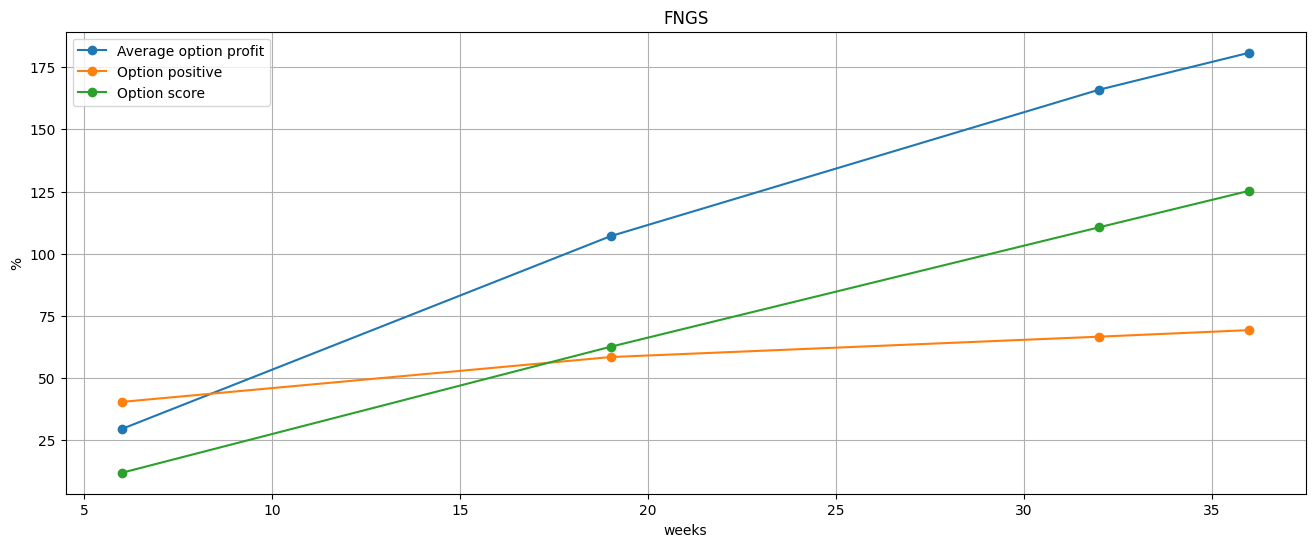

In [8]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='o')
plt.plot(option_weeks, option_positive, label='Option positive', marker='o')
plt.plot(option_weeks, option_score, label='Option score', marker='o')
# plt.axhline(y=0, color='k', linestyle='--')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

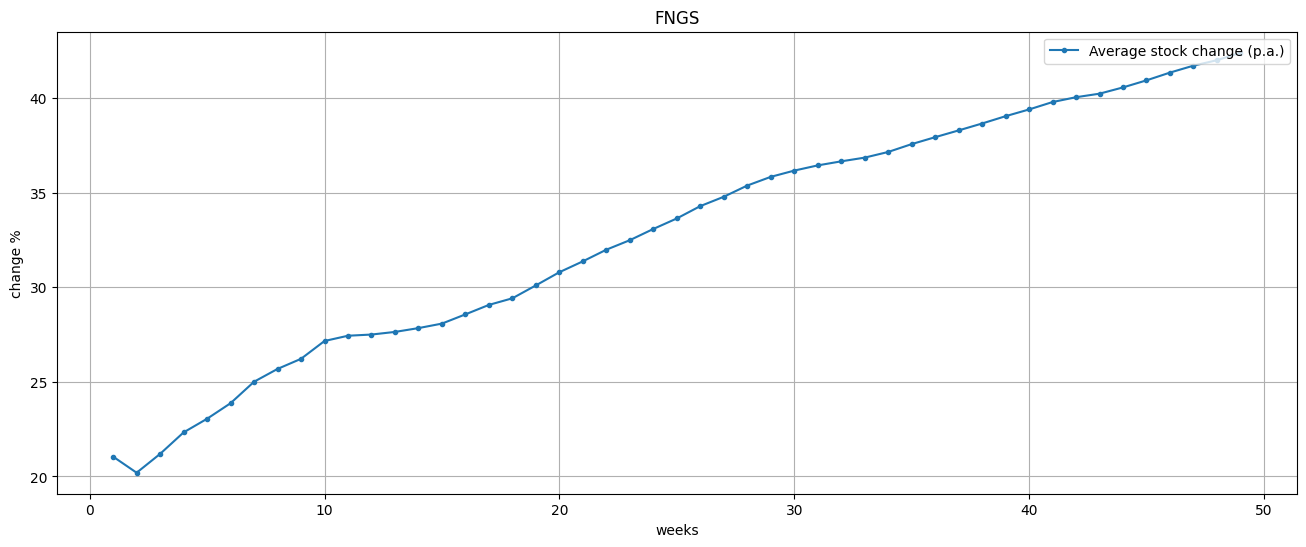

In [9]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()
